drop all cols with strings and unvaluable info like index
Always make sure it is sorted correctly by time and station
edit time of year with cos/sin "encode"
df['day_of_year'] = df['valid_time'].dt.dayofyear
?? subrtract a row in setting forecast hours ??

In [32]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append(".")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model
from comet_ml import Optimizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import os
import datetime as dt
from dateutil.parser import parse
from tqdm import tqdm
import re
import emd
import statistics as st
from multiprocessing import Process

In [38]:
df1 = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_feature_weights_western_plateau_0.005_100.csv"
)
df2 = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_feature_weights_western_plateau_5e-05_300.csv"
)
df3 = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_feature_weights_western_plateau_5e-07_500.csv"
)

the_df = df1.merge(df2, on="feature")
the_df = the_df.merge(df3, on="feature")
the_df = the_df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y", "Unnamed: 0"])
the_df = the_df.rename(
    columns={
        "trial --100_0.005": "trial_1",
        "trial --300_5e-05": "trial_2",
        "trial --500_5e-07": "trial_3",
    }
)
the_df.head()

,feature,trial_1,trial_2,trial_3
0,11_nlcd_ADDI,1.531708,1.008043,1.009792
1,19_aspect_ADDI,1.531708,1.008043,1.009792
2,21_aspect_ADDI,1.531708,1.008043,1.009792
3,21_nlcd_ADDI,1.531708,1.008043,1.009792
4,22_aspect_ADDI,1.531708,1.008043,1.009792


In [39]:
the_df["trial_2"] = the_df["trial_2"] ** 100
the_df["trial_1"] = the_df["trial_1"] ** 10
the_df["trial_3"] = the_df["trial_3"] ** 100
the_df.head()

,feature,trial_1,trial_2,trial_3
0,11_nlcd_ADDI,71.081925,2.227978,2.649556
1,19_aspect_ADDI,71.081925,2.227978,2.649556
2,21_aspect_ADDI,71.081925,2.227978,2.649556
3,21_nlcd_ADDI,71.081925,2.227978,2.649556
4,22_aspect_ADDI,71.081925,2.227978,2.649556


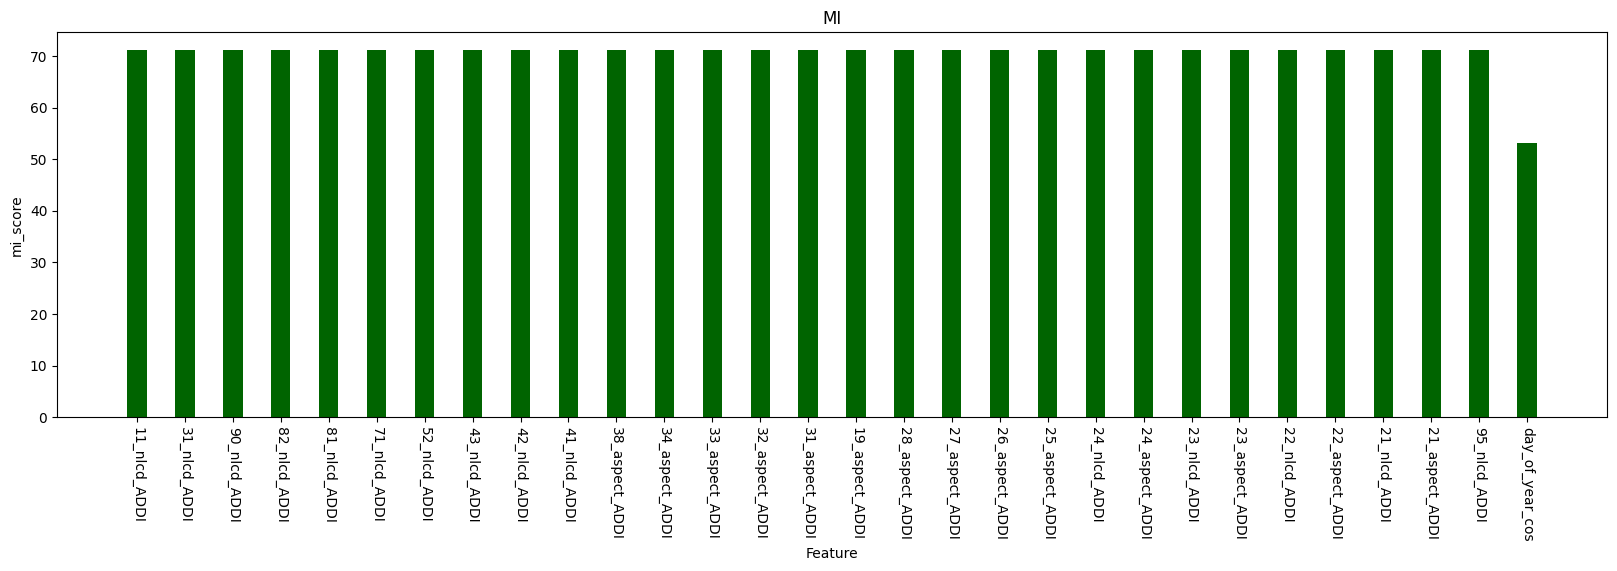

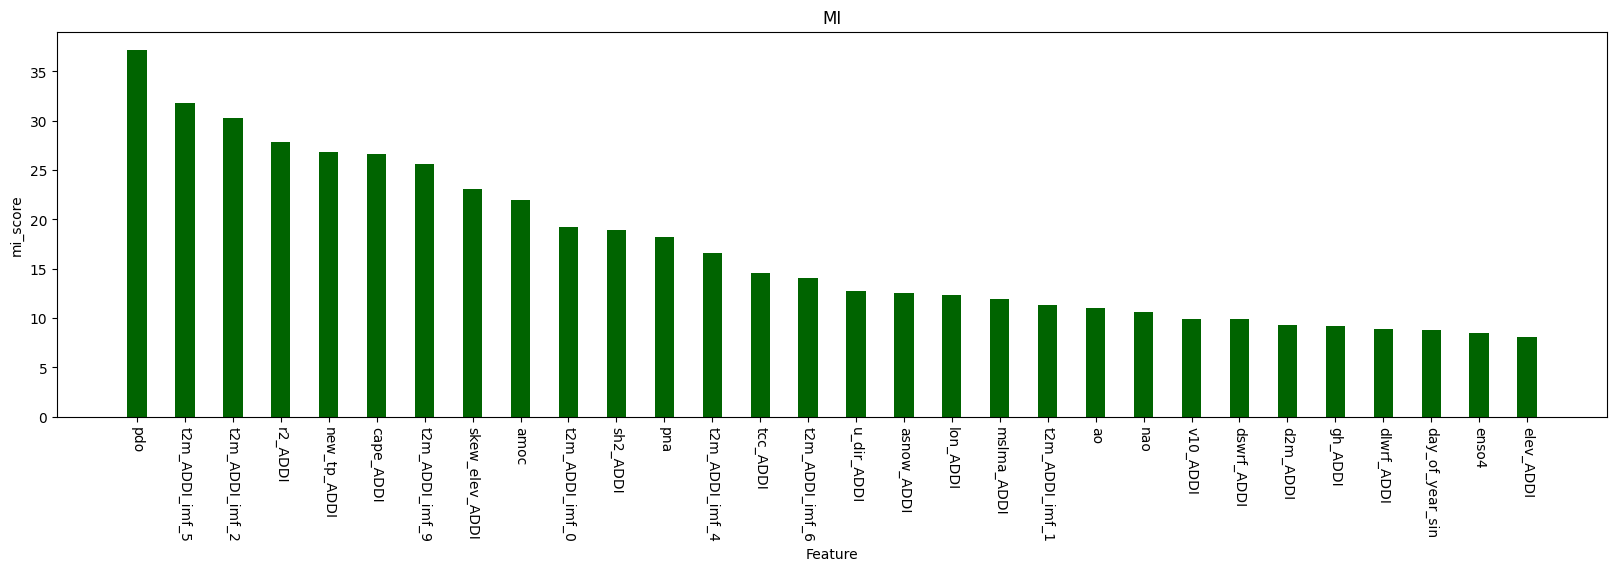

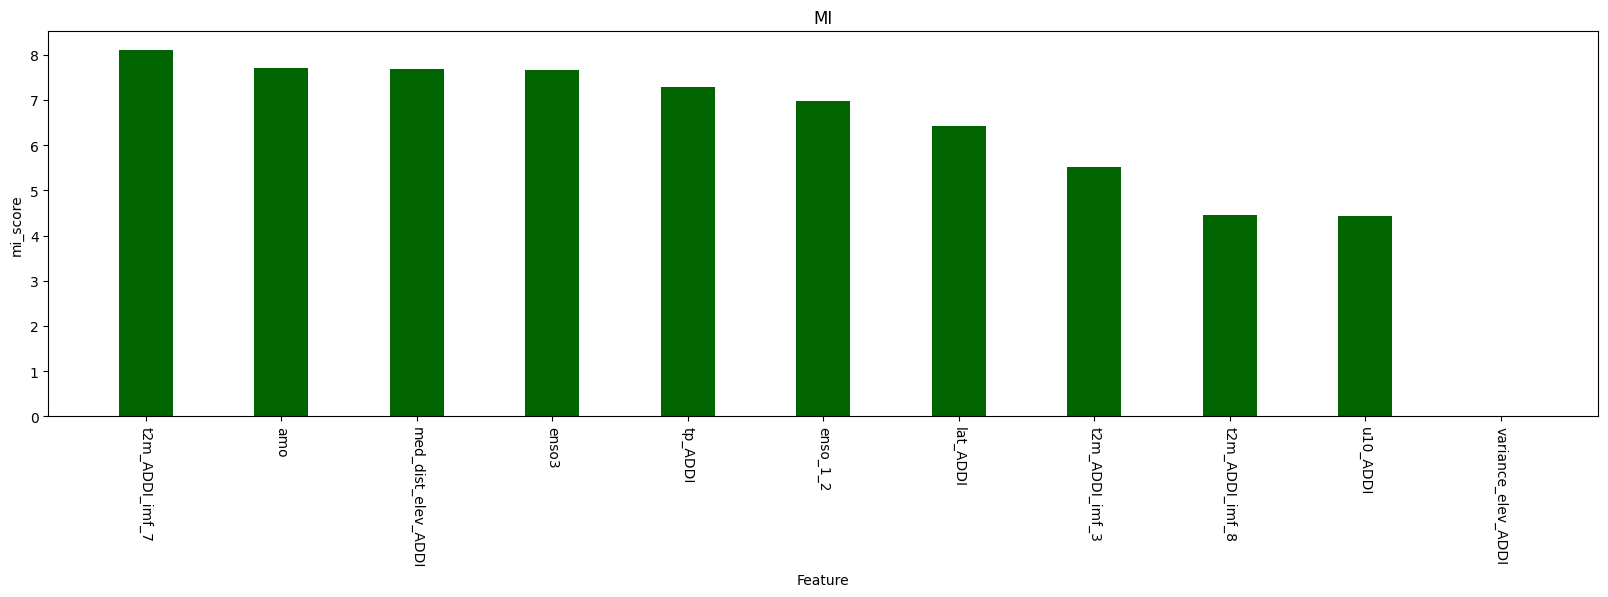

In [40]:
b = 0
e = 30
the_df = the_df.sort_values(by="trial_1", ascending=False)
for i in np.arange(0, len(df1["feature"]), 30):
    fig = plt.figure(figsize=(20, 5))
    plt.bar(
        the_df["feature"].iloc[b:e],
        the_df["trial_1"].iloc[b:e],
        color="darkgreen",
        width=0.4,
    )

    plt.xlabel("Feature")
    plt.xticks(rotation=270)
    plt.ylabel("mi_score")
    plt.title("MI")
    plt.show()
    b += 30
    e += 30

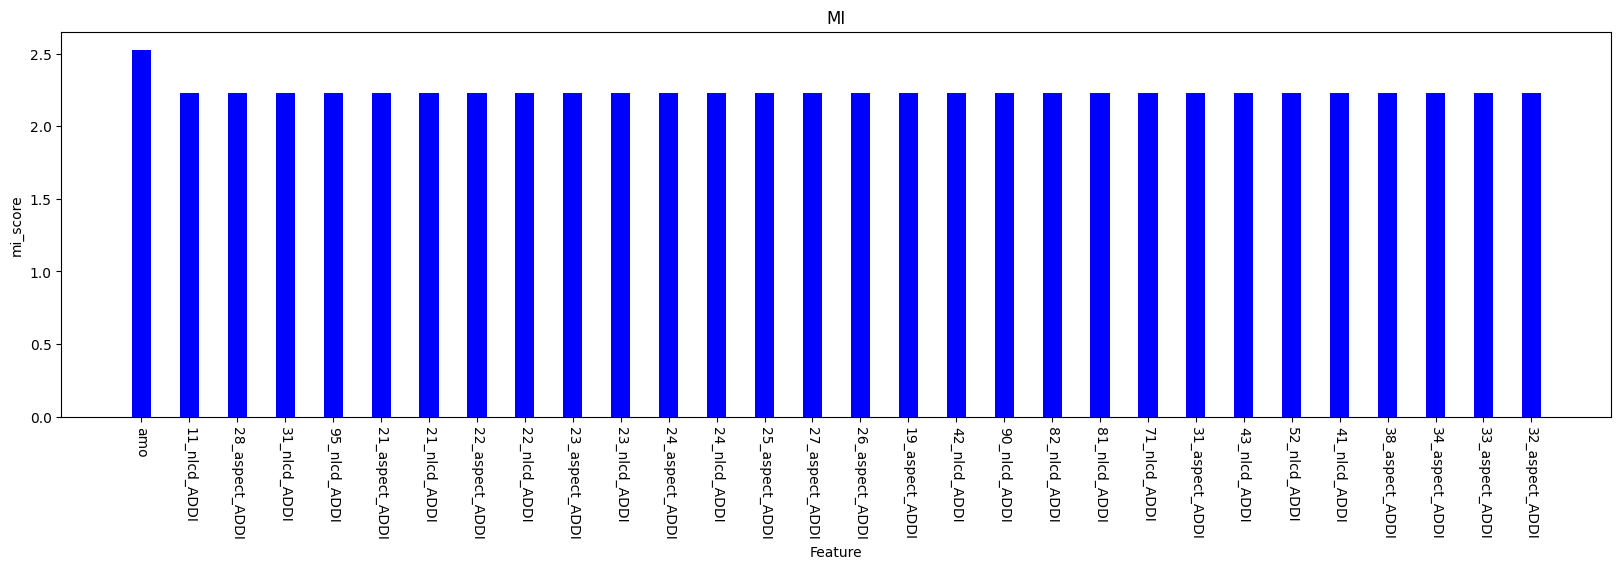

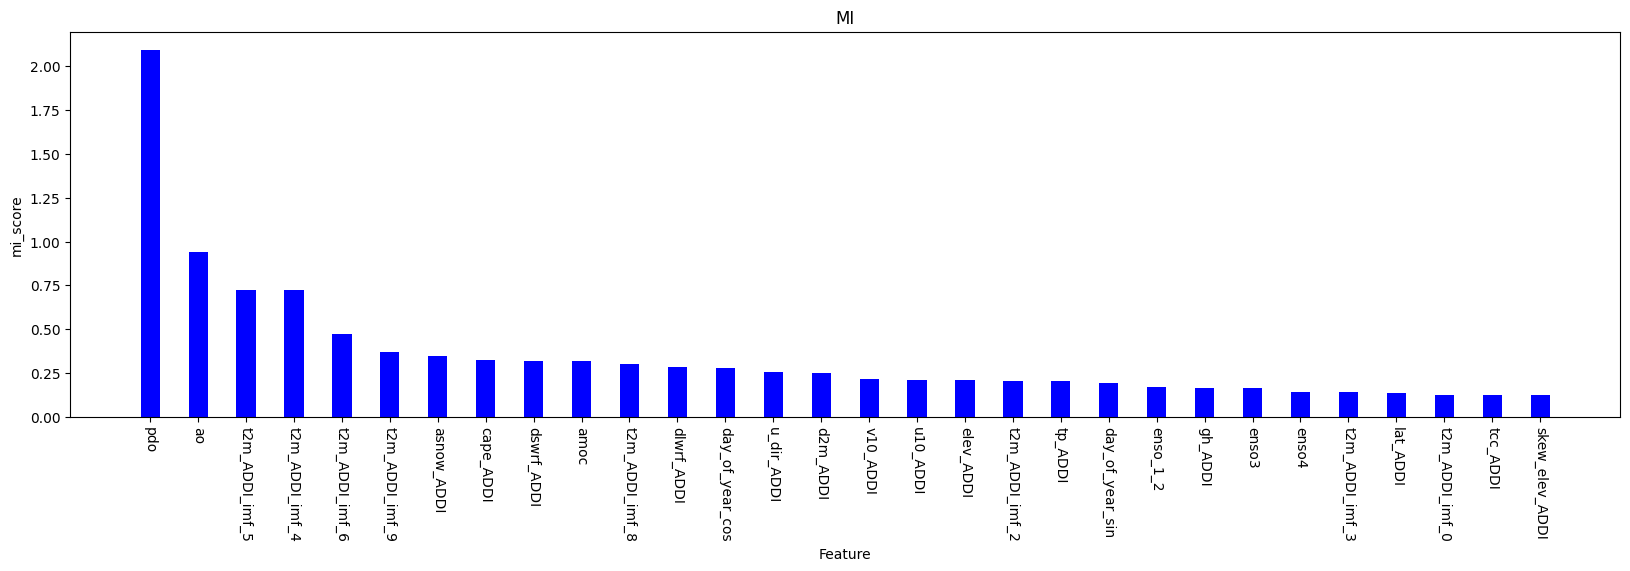

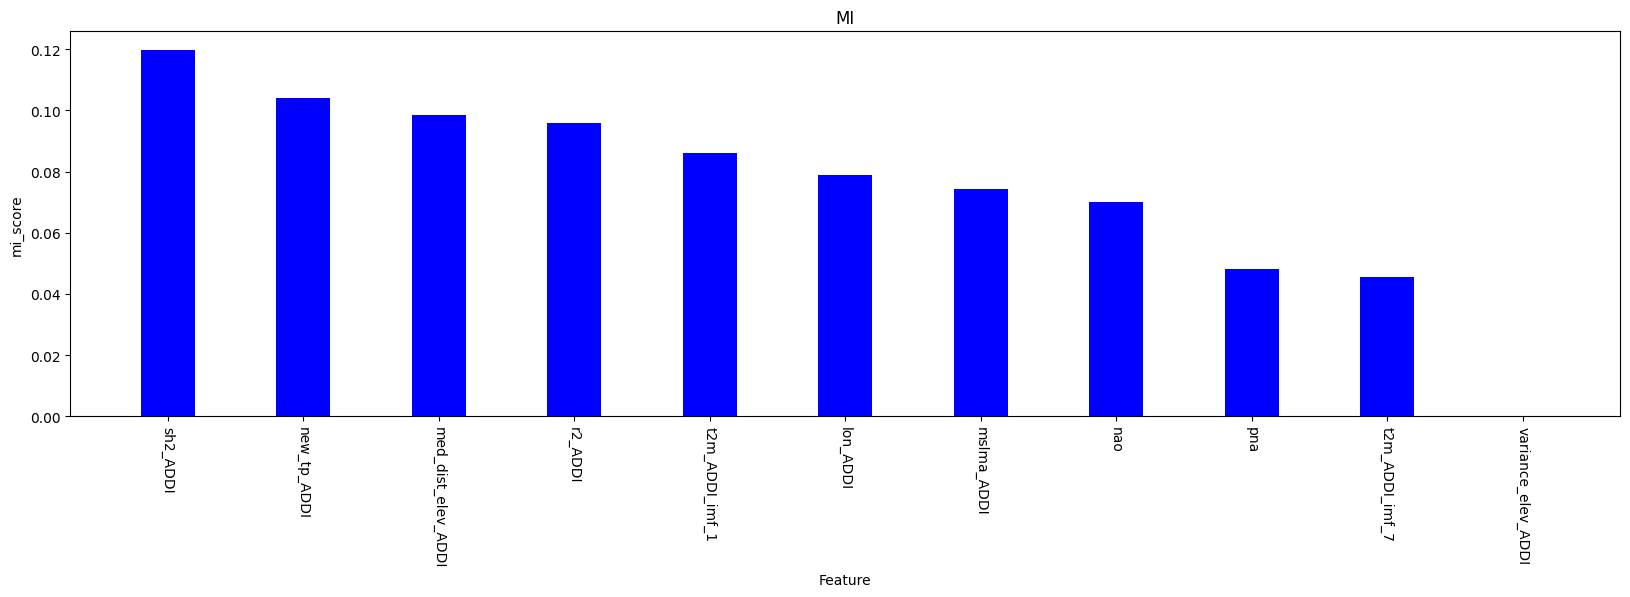

In [41]:
b = 0
e = 30
the_df = the_df.sort_values(by="trial_2", ascending=False)
for i in np.arange(0, len(df1["feature"]), 30):
    fig = plt.figure(figsize=(20, 5))
    plt.bar(
        the_df["feature"].iloc[b:e],
        the_df["trial_2"].iloc[b:e],
        color="blue",
        width=0.4,
    )

    plt.xlabel("Feature")
    plt.xticks(rotation=270)
    plt.ylabel("mi_score")
    plt.title("MI")
    plt.show()
    b += 30
    e += 30

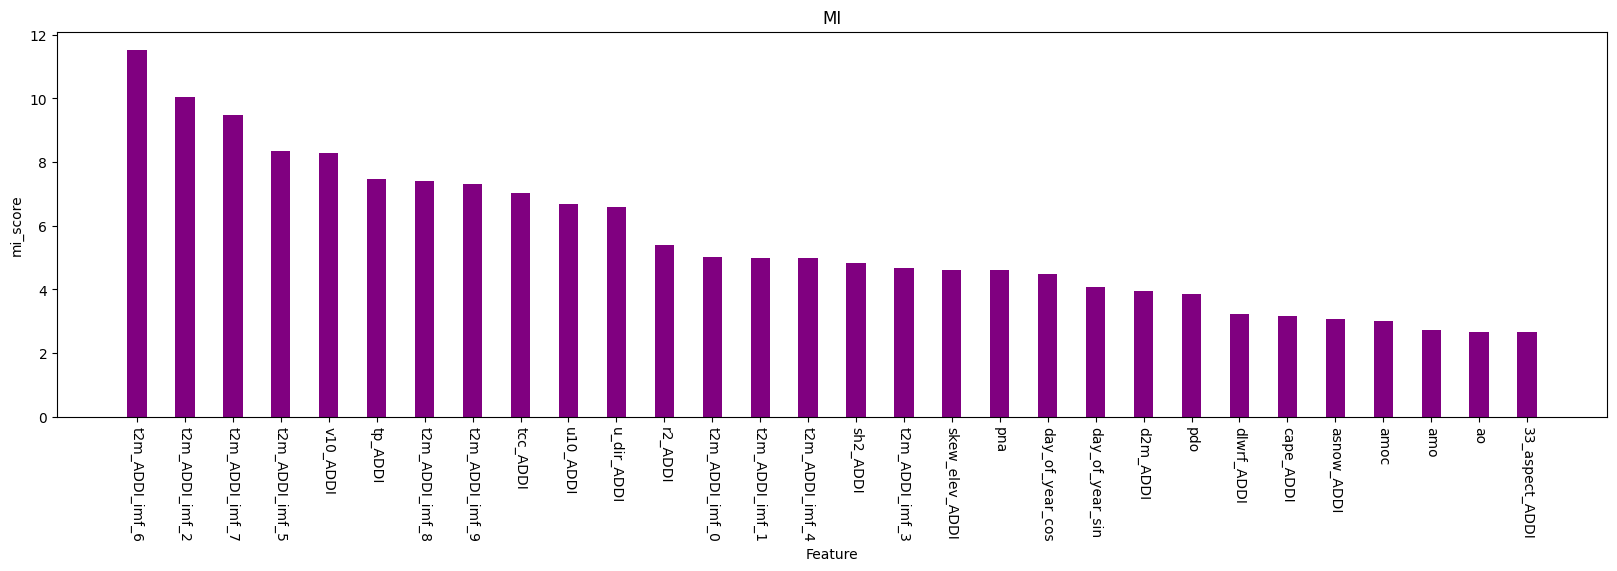

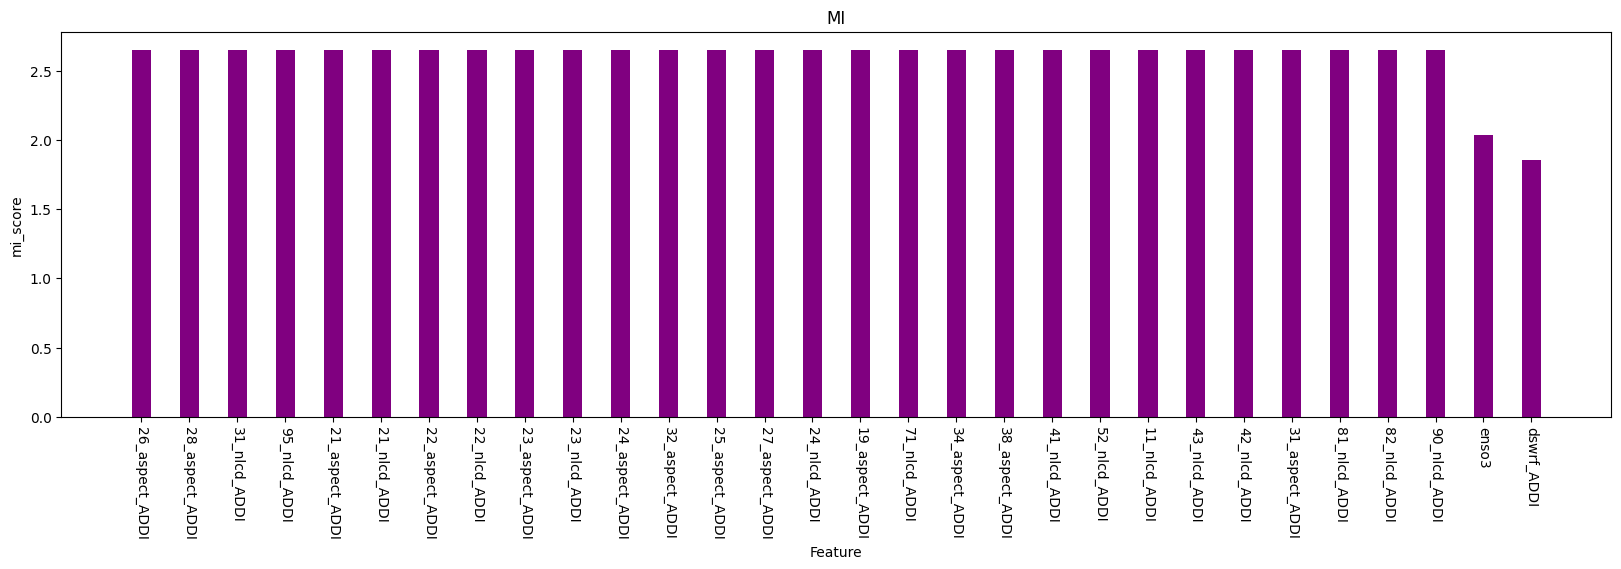

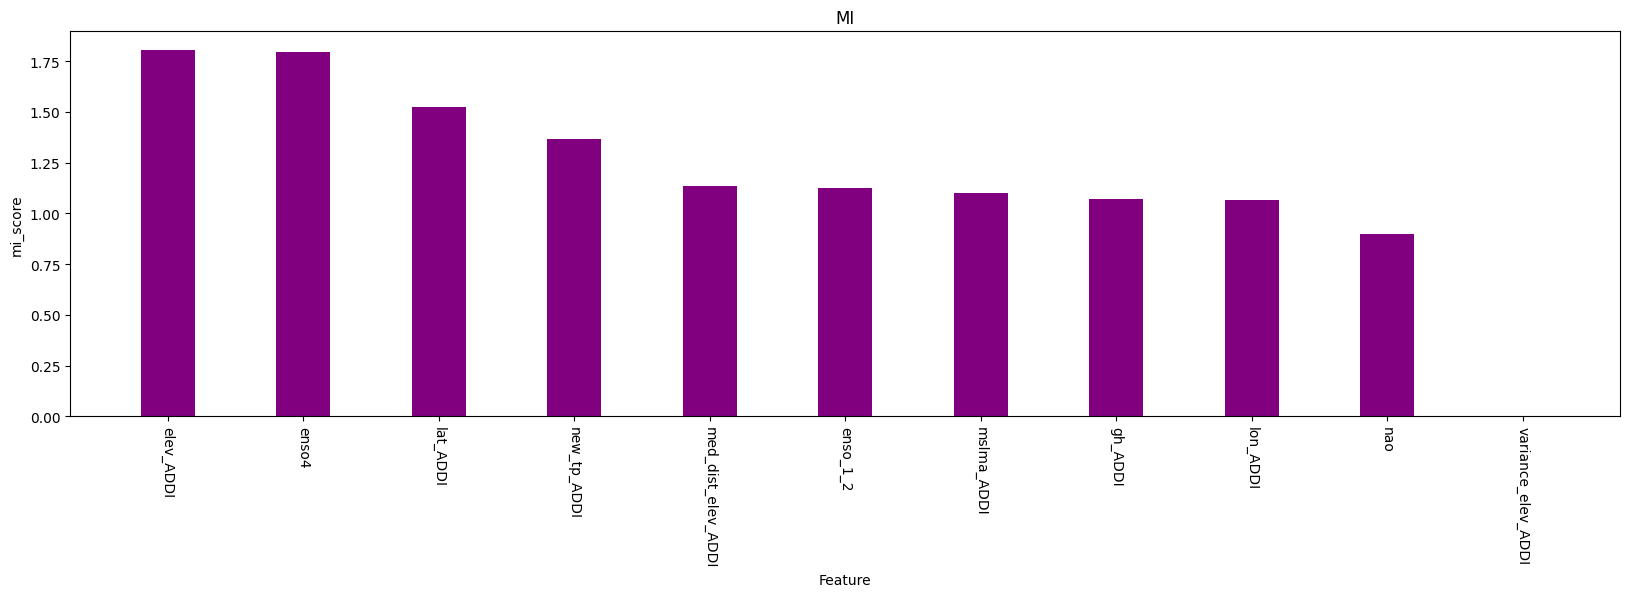

In [42]:
b = 0
e = 30
the_df = the_df.sort_values(by="trial_3", ascending=False)
for i in np.arange(0, len(df1["feature"]), 30):
    fig = plt.figure(figsize=(20, 5))

    plt.bar(
        the_df["feature"].iloc[b:e],
        the_df["trial_3"].iloc[b:e],
        color="purple",
        width=0.4,
    )

    plt.xlabel("Feature")
    plt.xticks(rotation=270)
    plt.ylabel("mi_score")
    plt.title("MI")
    plt.show()
    b += 30
    e += 30

In [3]:
def col_drop(df):
    df = df.drop(
        columns=[
            "day_of_year",
            "flag",
            "station",
            "latitude",
            "longitude",
            "t2m",
            "sh2",
            "d2m",
            "r2",
            "u10",
            "v10",
            "tp",
            "mslma",
            "orog",
            "tcc",
            "asnow",
            "cape",
            "dswrf",
            "dlwrf",
            "gh",
            "u_total",
            "u_dir",
            "new_tp",
            "lat",
            "lon",
            "elev",
            "tair",
            "ta9m",
            "td",
            "relh",
            "srad",
            "pres",
            "mslp",
            "wspd_sonic",
            "wmax_sonic",
            "wdir_sonic",
            "precip_total",
            "snow_depth",
            "day_of_year",
            "day_of_year_sin",
            "day_of_year_cos",
            "11_nlcd",
            "21_nlcd",
            "22_nlcd",
            "23_nlcd",
            "24_nlcd",
            "31_nlcd",
            "41_nlcd",
            "42_nlcd",
            "43_nlcd",
            "52_nlcd",
            "71_nlcd",
            "81_nlcd",
            "82_nlcd",
            "90_nlcd",
            "95_nlcd",
            "19_aspect",
            "21_aspect",
            "24_aspect",
            "27_aspect",
            "28_aspect",
            "22_aspect",
            "23_aspect",
            "25_aspect",
            "26_aspect",
            "31_aspect",
            "33_aspect",
            "32_aspect",
            "34_aspect",
            "38_aspect",
            "std_elev",
            "variance_elev",
            "skew_elev",
            "med_dist_elev",
        ]
    )
    df = df[df.columns.drop(list(df.filter(regex="time")))]
    df = df[df.columns.drop(list(df.filter(regex="station")))]
    df = df[df.columns.drop(list(df.filter(regex="tair")))]
    df = df[df.columns.drop(list(df.filter(regex="ta9m")))]
    df = df[df.columns.drop(list(df.filter(regex="td")))]
    df = df[df.columns.drop(list(df.filter(regex="relh")))]
    df = df[df.columns.drop(list(df.filter(regex="srad")))]
    df = df[df.columns.drop(list(df.filter(regex="pres")))]
    df = df[df.columns.drop(list(df.filter(regex="wspd")))]
    df = df[df.columns.drop(list(df.filter(regex="wmax")))]
    df = df[df.columns.drop(list(df.filter(regex="wdir")))]
    df = df[df.columns.drop(list(df.filter(regex="precip_total")))]
    df = df[df.columns.drop(list(df.filter(regex="snow_depth")))]

    return df

In [4]:
def get_flag(hrrr_df):
    """
    Create a flag column in the input DataFrame indicating consecutive hourly time intervals.

    This function takes a DataFrame containing weather data for different stations, with a 'station' column
    representing the station ID and a 'valid_time' column containing timestamps of the weather data.
    It calculates the time difference between consecutive timestamps for each station and marks it as 'True'
    in a new 'flag' column if the difference is exactly one hour, indicating consecutive hourly time intervals.
    Otherwise, it marks the 'flag' as 'False'.

    Parameters:
    hrrr_df (pandas.DataFrame): Input DataFrame containing weather data for different stations.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional 'flag' column indicating consecutive hourly time intervals.

    Example:
      station           valid_time   flag
    0        1 2023-08-01 00:00:00   True
    1        1 2023-08-01 01:00:00   False
    2        1 2023-08-01 03:00:00   False
    3        2 2023-08-01 08:00:00   True
    4        2 2023-08-01 09:00:00   False
    5        2 2023-08-01 11:00:00   True
    """

    # Get unique station IDs
    stations_ls = hrrr_df["station"].unique()

    # Define a time interval of one hour
    one_hour = dt.timedelta(hours=1)

    # Initialize a list to store flags for each time interval
    flag_ls = []

    # Loop through each station and calculate flags for consecutive hourly time intervals
    for station in stations_ls:
        # Filter DataFrame for the current station
        df = hrrr_df[hrrr_df["station"] == station]

        # Get the list of valid_time timestamps for the current station
        time_ls = df["valid_time"].tolist()

        # Compare each timestamp with the next one to determine consecutive intervals
        for now, then in zip(time_ls, time_ls[1:]):
            if now + one_hour == then:
                flag_ls.append(True)
            else:
                flag_ls.append(False)

    # Append an extra True to indicate the last time interval (since it has no next timestamp for comparison)
    flag_ls.append(True)

    # Add the 'flag' column to the DataFrame
    hrrr_df["flag"] = flag_ls

    return hrrr_df

In [5]:
def nwp_error(target, station, df):
    vars_dict = {
        "t2m": "tair",
        "mslma": "pres",
    }
    nysm_var = vars_dict.get(target)

    df["target_error"] = df[f"{target}_{station}"] - df[f"{nysm_var}_{station}"]
    return df

In [6]:
def encode(data, col, max_val, valid_times):
    data["valid_time"] = valid_times
    data = data[data.columns.drop(list(data.filter(regex="day")))]
    data["day_of_year"] = data["valid_time"].dt.dayofyear
    data[col + "_sin"] = np.sin(2 * np.pi * data[col] / max_val).astype(float)
    data[col + "_cos"] = np.cos(2 * np.pi * data[col] / max_val)
    data = data.drop(columns=["valid_time", "day_of_year"]).astype(float)

    return data

In [7]:
def format_climate_df(data_path):
    """
    Formats a climate data file located at the specified `data_path` into a pandas DataFrame.

    Args:
        data_path (str): The file path for the climate data file.

    Returns:
        pandas.DataFrame: A DataFrame containing the climate data, with the first column renamed to "year".
    """
    raw_index = np.loadtxt(f"{data_path}")
    cl_index = pd.DataFrame(raw_index)
    cl_index = cl_index.rename(columns={0: "year"})
    return cl_index

In [8]:
def get_clim_indexes(df, valid_times):
    """
    Fetch climate indexes data and add corresponding index values to the input DataFrame.

    This function takes a DataFrame (`df`) containing weather data with a 'valid_time' column representing
    timestamps. It reads climate indexes data from text files in the specified directory and extracts index
    values corresponding to the month and year of each timestamp in the DataFrame. The extracted index values
    are then added to the DataFrame with new columns named after each index.

    Parameters:
    df (pandas.DataFrame): Input DataFrame containing weather data with a 'valid_time' column.

    Returns:
    pandas.DataFrame: The input DataFrame with additional columns for each climate index containing their values.
    """

    clim_df_path = "/home/aevans/nwp_bias/src/correlation/data/indexes/"
    directory = os.listdir(clim_df_path)
    df["valid_time"] = valid_times

    # Loop through each file in the specified directory
    for d in directory:
        if d.endswith(".txt"):
            # Read the climate index data from the file and format it into a DataFrame
            clim_df = format_climate_df(f"{clim_df_path}{d}")
            index_name = d.split(".")[0]

            clim_ind_ls = []
            for t, _ in enumerate(df["valid_time"]):
                time_obj = df["valid_time"].iloc[t]
                dt_object = parse(str(time_obj))
                year = dt_object.strftime("%Y")
                month = dt_object.strftime("%m")
                # Filter the climate DataFrame to get data for the specific year
                df1 = clim_df.loc[clim_df["year"] == int(year)]
                df1 = df1.drop(columns="year")
                row_list = df1.values
                keys = df1.keys()
                key_vals = keys.tolist()

                # Extract the index value corresponding to the month of the timestamp
                the_list = []
                for n, _ in enumerate(key_vals):
                    val1 = key_vals[n]
                    val2 = row_list[0, n]
                    tup = (val1, val2)
                    the_list.append(tup)
                for k, r in the_list:
                    if str(k).zfill(2) == month:
                        clim_ind_ls.append(r)

            # Add the climate index values as a new column in the DataFrame
            df[index_name] = clim_ind_ls

    df = df.drop(columns="valid_time")
    return df

In [9]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/clean_parquets/nysm_cats/cleaned_rough_lstm_nysmcat_Western Plateau.parquet"
)
df = df.dropna()

In [10]:
valid_times = df["valid_time"].tolist()

In [11]:
# columns to reintigrate back into the df after model is done running
cols_to_carry = cols_to_carry = [
    "valid_time",
    "flag",
    "day_of_year_sin",
    "day_of_year_cos",
]

In [12]:
df = get_flag(df)
df = nwp_error("t2m", "ADDI", df)

In [13]:
new_df = df.copy()

In [14]:
def normalize_df(df, valid_times):
    print("init normalizer")
    df = col_drop(df)
    the_df = df.dropna()
    for k, r in the_df.items():
        if len(the_df[k].unique()) == 1:
            org_str = str(k)
            my_str = org_str[:-5]
            vals = the_df.filter(regex=my_str)
            vals = vals.loc[0].tolist()
            means = st.mean(vals)
            stdevs = st.pstdev(vals)
            the_df[k] = (the_df[k] - means) / stdevs

            the_df = the_df.fillna(0)
            # |sh2|d2m|r2|u10|v10|tp|mslma|tcc|asnow|cape|dswrf|dlwrf|gh|utotal|u_dir|new_tp
        if re.search(
            "t2m",
            k,
        ):
            ind_val = the_df.columns.get_loc(k)
            x = the_df[k]
            imf = emd.sift.sift(x)
            the_df = the_df.drop(columns=k)
            for i in range(imf.shape[1]):
                imf_ls = imf[:, i].tolist()
                # Inserting the column at the
                # beginning in the DataFrame
                my_loc = ind_val + i
                the_df.insert(loc=(my_loc), column=f"{k}_imf_{i}", value=imf_ls)

        else:
            means = st.mean(the_df[k])
            stdevs = st.pstdev(the_df[k])
            the_df[k] = (the_df[k] - means) / stdevs

    final_df = the_df.fillna(0)
    print("!!! Dropping Columns !!!")
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="latitude")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="longitude")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="u_total")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="mslp")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="orog")))]

    print("--- configuring data ---")
    final_df = encode(final_df, "day_of_year", 366, valid_times)
    final_df = get_clim_indexes(final_df, valid_times)
    new_features = list(final_df.columns.difference(["target_error"]))
    print("---normalize successful---")

    return final_df, new_features

In [15]:
def normalize_df_station(df):
    print("init normalizer")
    the_df = df.dropna()
    for k, r in the_df.items():
        if len(the_df[k].unique()) == 1:
            org_str = str(k)
            my_str = org_str[:-5]
            vals = the_df.filter(regex=my_str)
            vals = vals.loc[0].tolist()
            means = st.mean(vals)
            stdevs = st.pstdev(vals)
            the_df[k] = (the_df[k] - means) / stdevs

            the_df = the_df.fillna(0)
        if not (len(the_df[k].unique()) == 1) and re.search("_ADDI", k):
            ind_val = the_df.columns.get_loc(k)
            x = the_df[k]
            imf = emd.sift.sift(x)
            the_df = the_df.drop(columns=k)
            for i in range(imf.shape[1]):
                imf_ls = imf[:, i].tolist()
                # Inserting the column at the
                # beginning in the DataFrame
                my_loc = ind_val + i
                the_df.insert(loc=(my_loc), column=f"{k}_imf_{i}", value=imf_ls)

        else:
            means = st.mean(the_df[k])
            stdevs = st.pstdev(the_df[k])
            the_df[k] = (the_df[k] - means) / stdevs

    final_df = the_df.fillna(0)
    print("!!! Dropping Columns !!!")
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="latitude")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="longitude")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="u_total")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="mslp")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="orog")))]
    new_features = list(final_df.columns.difference(["target_error"]))
    print("---normalize successful---")
    return final_df, new_features

## create train and test set

In [16]:
target_sensor = "target_error"
the_df, new_features = normalize_df(new_df, valid_times)

forecast_lead = 30
target = f"{target_sensor}_lead_{forecast_lead}"

the_df[target] = the_df[target_sensor].shift(-forecast_lead)
the_df = the_df.iloc[:-forecast_lead]

init normalizer


/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Conve

!!! Dropping Columns !!!
--- configuring data ---


/tmp/tmp.eVhkDnQWpn/ipykernel_13459/829324959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day_of_year"] = data["valid_time"].dt.dayofyear
/tmp/tmp.eVhkDnQWpn/ipykernel_13459/829324959.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + "_sin"] = np.sin(2 * np.pi * data[col] / max_val).astype(float)
/tmp/tmp.eVhkDnQWpn/ipykernel_13459/829324959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

---normalize successful---


# Normalize

In [17]:
length = len(the_df)

test_len = int(length * 0.75)

df_train = the_df.iloc[:test_len].copy()
df_test = the_df.iloc[test_len:].copy()

print("Test Set Fraction", len(df_test) / len(the_df))

Test Set Fraction 0.25003339121143314


## Normalize

In [18]:
for c in cols_to_carry:
    df_train[c] = df[c]
    df_test[c] = df[c]

In [19]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [20]:
df_test

,t2m_ADDI_imf_0,t2m_ADDI_imf_1,t2m_ADDI_imf_2,t2m_ADDI_imf_3,t2m_ADDI_imf_4,t2m_ADDI_imf_5,t2m_ADDI_imf_6,t2m_ADDI_imf_7,t2m_ADDI_imf_8,t2m_ADDI_imf_9,...,enso4,enso_1_2,pna,enso3,ao,pdo,nao,target_error_lead_30,valid_time,flag
16845,0.241526,0.297581,0.460891,2.755017,-1.468827,0.280847,-4.253160,5.165458,-1.203823,1.216701,...,-0.68,-1.12,0.68,-1.03,0.093,-2.52,-0.33,0.466901,2021-11-22 10:00:00,True
16846,-0.164721,-0.042090,0.362151,2.474688,-1.453629,0.263343,-4.250228,5.158583,-1.203730,1.216437,...,-0.68,-1.12,0.68,-1.03,0.093,-2.52,-0.33,0.799416,2021-11-22 11:00:00,True
16847,0.105367,-0.486741,0.219456,2.184923,-1.436017,0.245770,-4.247241,5.151696,-1.203636,1.216173,...,-0.68,-1.12,0.68,-1.03,0.093,-2.52,-0.33,-0.351758,2021-11-22 12:00:00,True
16848,-0.017604,-0.715117,0.060210,1.887383,-1.416064,0.228130,-4.244199,5.144799,-1.203542,1.215909,...,-0.68,-1.12,0.68,-1.03,0.093,-2.52,-0.33,-0.158703,2021-11-22 13:00:00,True
16849,-0.114607,-0.689329,-0.090533,1.583723,-1.393846,0.210426,-4.241100,5.137889,-1.203447,1.215644,...,-0.68,-1.12,0.68,-1.03,0.093,-2.52,-0.33,-0.263606,2021-11-22 14:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22456,-0.253649,-1.508868,0.229911,8.899499,4.637280,1.112167,-5.254929,-0.400453,0.520442,0.340615,...,-0.84,-0.46,-0.96,-0.81,-2.719,-9.90,-0.22,0.136727,2022-12-30 13:00:00,True
22457,-0.029539,-0.930426,0.733629,8.857566,4.741251,1.117889,-5.254474,-0.401975,0.520271,0.340688,...,-0.84,-0.46,-0.96,-0.81,-2.719,-9.90,-0.22,0.119368,2022-12-30 14:00:00,True
22458,0.110616,-0.024843,1.202153,8.800177,4.844479,1.123339,-5.253991,-0.403489,0.520099,0.340761,...,-0.84,-0.46,-0.96,-0.81,-2.719,-9.90,-0.22,-0.694242,2022-12-30 15:00:00,True
22459,-0.078151,0.957164,1.602189,8.727438,4.946911,1.128514,-5.253480,-0.404995,0.519927,0.340834,...,-0.84,-0.46,-0.96,-0.81,-2.719,-9.90,-0.22,-0.717157,2022-12-30 16:00:00,True


## Create LSTM

In [21]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length):
        self.dataframe = dataframe
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        keep_sample = self.dataframe.iloc[i]["flag"]
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start : (i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0 : (i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i], keep_sample

In [22]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 3

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()
        c0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(
            hn[0]
        ).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [23]:
class EarlyStopper:
    def __init__(self, patience, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [24]:
def remove_elements_from_batch(X, y, s):
    cond = np.where(s)
    return X[cond], y[cond], s[cond]

In [25]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    with tqdm(data_loader, unit="batch") as tepoch:
        for X, y, s in tepoch:
            X, y, s = remove_elements_from_batch(X, y, s)
            output = model(X)
            loss = loss_function(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    # loss
    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        with tqdm(data_loader, unit="batch") as tepoch:
            for X, y, s in tepoch:
                X, y, s = remove_elements_from_batch(X, y, s)
                output = model(X)
                total_loss += loss_function(output, y).item()

    # loss
    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

    return avg_loss

In [26]:
per_df = pd.DataFrame()

In [27]:
new_features

['11_nlcd_ADDI',
 '11_nlcd_BELM',
 '11_nlcd_COHO',
 '11_nlcd_DELE',
 '11_nlcd_ELMI',
 '11_nlcd_GROV',
 '11_nlcd_HART',
 '11_nlcd_OLEA',
 '11_nlcd_RAND',
 '19_aspect_ADDI',
 '19_aspect_BELM',
 '19_aspect_COHO',
 '19_aspect_DELE',
 '19_aspect_ELMI',
 '19_aspect_GROV',
 '19_aspect_HART',
 '19_aspect_OLEA',
 '19_aspect_RAND',
 '21_aspect_ADDI',
 '21_aspect_BELM',
 '21_aspect_COHO',
 '21_aspect_DELE',
 '21_aspect_ELMI',
 '21_aspect_GROV',
 '21_aspect_HART',
 '21_aspect_OLEA',
 '21_aspect_RAND',
 '21_nlcd_ADDI',
 '21_nlcd_BELM',
 '21_nlcd_COHO',
 '21_nlcd_DELE',
 '21_nlcd_ELMI',
 '21_nlcd_GROV',
 '21_nlcd_HART',
 '21_nlcd_OLEA',
 '21_nlcd_RAND',
 '22_aspect_ADDI',
 '22_aspect_BELM',
 '22_aspect_COHO',
 '22_aspect_DELE',
 '22_aspect_ELMI',
 '22_aspect_GROV',
 '22_aspect_HART',
 '22_aspect_OLEA',
 '22_aspect_RAND',
 '22_nlcd_ADDI',
 '22_nlcd_BELM',
 '22_nlcd_COHO',
 '22_nlcd_DELE',
 '22_nlcd_ELMI',
 '22_nlcd_GROV',
 '22_nlcd_HART',
 '22_nlcd_OLEA',
 '22_nlcd_RAND',
 '23_aspect_ADDI',
 '23_aspe

In [29]:
batch_size = 150
sequence_length = 250
learning_rate = [5e-3, 5e-6, 5e-9]
num_hidden_units = [100, 250, 500]
num_layers = 8
station = "ADDI"

final_df = pd.DataFrame()
final_df["feature"] = new_features


for nhu in num_hidden_units:
    for lr in learning_rate:
        feature_ls = []
        loss_ls = []
        for feature in new_features:
            features = []
            for x, _ in enumerate(new_features):
                if new_features[x] == feature:
                    continue
                else:
                    features.append(new_features[x])

            # features = new_features
            # features.remove(feature)
            print(len(features))
            torch.manual_seed(101)

            train_dataset = SequenceDataset(
                df_train,
                target=target,
                features=features,
                sequence_length=sequence_length,
            )
            test_dataset = SequenceDataset(
                df_test,
                target=target,
                features=features,
                sequence_length=sequence_length,
            )

            train_loader = DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True
            )
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            X, y, s = next(iter(train_loader))

            print("Features shape:", X.shape)
            print("Target shape:", y.shape)

            model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=nhu)
            loss_function = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            early_stopper = EarlyStopper(patience=25, min_delta=0)

            print("Untrained test\n--------")
            test_model(test_loader, model, loss_function)
            print()

            for ix_epoch in range(2):
                print(f"Epoch {ix_epoch}\n---------")
                train_loss = train_model(
                    train_loader, model, loss_function, optimizer=optimizer
                )
                val_loss = test_model(test_loader, model, loss_function)
                print()

            print("Successful Experiment")

        final_df[f"learning_Rate: {lr}"] = loss_ls

549
Features shape: torch.Size([150, 250, 549])
Target shape: torch.Size([150])
Untrained test
--------


100%|██████████| 38/38 [00:13<00:00,  2.72batch/s]


Test loss: 1.0051191276625584

Epoch 0
---------


100%|██████████| 113/113 [01:49<00:00,  1.03batch/s]


Train loss: 0.8021079512824


100%|██████████| 38/38 [00:13<00:00,  2.76batch/s]


Test loss: 1.2039608602461063

Epoch 1
---------


100%|██████████| 113/113 [01:43<00:00,  1.10batch/s]


Train loss: 0.645814739497362


100%|██████████| 38/38 [00:13<00:00,  2.78batch/s]


Test loss: 1.2674073396544707

Successful Experiment
549
Features shape: torch.Size([150, 250, 549])
Target shape: torch.Size([150])
Untrained test
--------


100%|██████████| 38/38 [00:13<00:00,  2.78batch/s]


Test loss: 1.0051191276625584

Epoch 0
---------


100%|██████████| 113/113 [01:41<00:00,  1.11batch/s]


Train loss: 0.8021079512824


100%|██████████| 38/38 [00:13<00:00,  2.77batch/s]


Test loss: 1.2039608602461063

Epoch 1
---------


100%|██████████| 113/113 [01:42<00:00,  1.10batch/s]


Train loss: 0.645814739497362


100%|██████████| 38/38 [00:13<00:00,  2.78batch/s]


Test loss: 1.2674073396544707

Successful Experiment
549
Features shape: torch.Size([150, 250, 549])
Target shape: torch.Size([150])
Untrained test
--------


100%|██████████| 38/38 [00:13<00:00,  2.79batch/s]


Test loss: 1.0051191276625584

Epoch 0
---------


100%|██████████| 113/113 [01:41<00:00,  1.12batch/s]


Train loss: 0.8021079512824


100%|██████████| 38/38 [00:13<00:00,  2.77batch/s]


Test loss: 1.2039608602461063

Epoch 1
---------


100%|██████████| 113/113 [01:42<00:00,  1.11batch/s]


Train loss: 0.645814739497362


100%|██████████| 38/38 [00:13<00:00,  2.77batch/s]


Test loss: 1.2674073396544707

Successful Experiment
549
Features shape: torch.Size([150, 250, 549])
Target shape: torch.Size([150])
Untrained test
--------


100%|██████████| 38/38 [00:13<00:00,  2.79batch/s]


Test loss: 1.0051191276625584

Epoch 0
---------


100%|██████████| 113/113 [01:41<00:00,  1.12batch/s]


Train loss: 0.8021079512824


100%|██████████| 38/38 [00:13<00:00,  2.78batch/s]


Test loss: 1.2039608602461063

Epoch 1
---------


100%|██████████| 113/113 [01:47<00:00,  1.05batch/s]


Train loss: 0.645814739497362


100%|██████████| 38/38 [00:14<00:00,  2.69batch/s]


Test loss: 1.2674073396544707

Successful Experiment
549
Features shape: torch.Size([150, 250, 549])
Target shape: torch.Size([150])
Untrained test
--------


100%|██████████| 38/38 [00:13<00:00,  2.75batch/s]


Test loss: 1.0051191276625584

Epoch 0
---------


 13%|█▎        | 15/113 [00:14<01:35,  1.02batch/s]


KeyboardInterrupt: 

In [33]:
new_features.index("d2m_ADDI")

282